# Automatic labelling of topics for United Nations General Debate Corpus (UNGDC) 

This program consists of two parts: First, the topics occurring in United Nations General Debate Corpus (UNGDC) are discovered.
Second, the discovered topics are automatically labelled using the pipeline offered as part of the publication 
“Automatic labelling of topics using neural embeddings” by Bhatia et al in 2016.

In the first part, using Gensim library in Python, an LDA model is trained on the corpus and semantic coherence measure
is used to find an optimal number of topics. The program outputs the optimal number of topics along with their 10 most frequent
words.

In the second part, the discovered topic along with their 10 most frequent words is fed to the pipeline in a .csv file.
Each line in the file  contains the topic id (here: 0 to 10) along with top n (here 10) words. The path to this file is updated in get_labels.py.

Finally, the get_labels.py should should be run by typing "python get_labels.py -cg –us -s ” in the command prompt.
It will give you candidate labels in a file with unsupervised and supervised labels printed on the console as well as in output files.
By default output files namely output_candidates, output_unsupervised, and output_supervised will be created in the same directory.



# Import the required packages

In [2]:
#Taken From:https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
from pprint import pprint
import numpy as np
import os,re
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Import the dataset
In this part, the corpus is read into a list (docs). Each file (each speech) in the corpus is an element in this list.


In [3]:
docs=[]
pattern='^[A-Z]{1,4}_[0-9]{2}_[0-9]{4}.txt$'
path='C:/UN/'
for (dirname, dirs, files) in os.walk(path):
   for filename in files:
        thefile = os.path.join(dirname,filename)
        with open (thefile,encoding='utf8',errors='ignore') as fin:
             if re.match(pattern, filename):

                doc=fin.read().strip('\n\t')
                docs.append(doc)       
print(len(docs))

7897


# Define a function for tokenizing and lemmatizing
In this part, some pre-processing is done on the corpus to get rid of the words that useful information, such as function words like the, or digits. The corpus is also lemmatized to avoid sparsity.

In [4]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)


# Create Biagram & Trigram Models 

In [5]:
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a trigram, add to document.
            docs[idx].append(token)


# Remove rare & common tokens 

In [6]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 41244
Number of documents: 7897


# Build The Model

In [7]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.008*"soviet_union" + 0.008*"republic_korea" + 0.004*"korean_peninsula" + 0.003*"korean" + 0.003*"cyprus" + 0.003*"foreign_policy" + 0.003*"viet" + 0.003*"super_power" + 0.002*"aligned_country" + 0.002*"south_east"'), (1, '0.004*"peace_keeping" + 0.003*"least_developed" + 0.002*"special_session" + 0.002*"south_african" + 0.002*"developed_developing" + 0.002*"programme_action" + 0.002*"prime_minister" + 0.001*"peaceful_settlement" + 0.001*"south_pacific" + 0.001*"this_connection"'), (2, '0.005*"syria" + 0.004*"syrian" + 0.004*"islamic" + 0.003*"sudan" + 0.003*"libya" + 0.003*"islamic_republic" + 0.003*"call_upon" + 0.002*"iraqi" + 0.002*"arab_emirate" + 0.002*"south_sudan"'), (3, '0.005*"central_african" + 0.003*"latin_american" + 0.003*"guinea_bissau" + 0.003*"trinidad_tobago" + 0.003*"central_america" + 0.003*"third_world" + 0.002*"central_american" + 0.002*"make_possible" + 0.002*"costa_rica" + 0.002*"western_sahara"'), (4, '0.005*"european_union" + 0.004*"small_island" + 0.00

# Find the optimal number of topics

In [8]:
#Using c_v Measure
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Create a model list and plot Coherence score against a number of topics

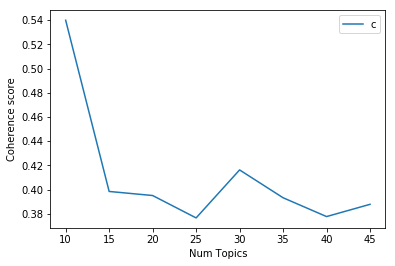

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=10, limit=50, step=5)
# Show graph
import matplotlib.pyplot as plt
limit=50; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The diagram shows that the optimal number of topics is 10.

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5399
Num Topics = 15  has Coherence Value of 0.3984
Num Topics = 20  has Coherence Value of 0.3951
Num Topics = 25  has Coherence Value of 0.3766
Num Topics = 30  has Coherence Value of 0.4162
Num Topics = 35  has Coherence Value of 0.3932
Num Topics = 40  has Coherence Value of 0.3777
Num Topics = 45  has Coherence Value of 0.3878


# Selecting The Optimal Model

In [25]:
#finding the number of topics that gives the highest Coherence Value 
max_cv=max(coherence_values)
#finding the index of the model with this numnber of topics
index_model=coherence_values.index(max_cv)
#print(index_model)
# Select the model and print the topics 
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

# Writing the topics along with the 10 most frequent words in a file

In [26]:
import re
with open('c://UNT//Topics_UN_Bg.csv','w') as fw:
    fw.write("topic_id,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9"+"\n")
    for i in optimal_model.print_topics():
        r1 = re.findall(r"\w+",i[1])
        line=str(i[0])
        for item in r1:
            if not item.isdigit():
                line=line+','+item
        fw.write(line+'\n')

# Displaying the file
This file is a csv file. Each line of the file contains a topic id along with 10 most common words for the topic.

In [27]:
from IPython.display import display
import pandas
df = pandas.read_csv("c://UNT//Topics_UN_Bg.csv")
display(df)

,topic_id,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9
0,0,republic_korea,korean_peninsula,korean,soviet_union,democratic_republic,peninsula,national_reconciliation,western_sahara,third_world,chad
1,1,third_world,african_union,ethiopia,south_african,soviet_union,democratic_republic,african_unity,industrialized_country,western_sahara,special_session
2,2,small_island,caribbean,trinidad_tobago,saint_lucia,twenty_first,millennium_development,agenda_sustainable,natural_disaster,middle_income,most_vulnerable
3,3,european_union,african_union,millennium_development,good_governance,around_world,bosnia_herzegovina,next_year,sierra_leone,twenty_first,syria
4,4,central_african,democratic_republic,african_union,guinea_bissau,guinea,millennium_development,south_sudan,african_continent,least_developed,congo
5,5,syria,syrian,islamic,libya,sudan,kingdom_saudi,soviet_union,yemen,third_world,weapon_mass
6,6,soviet_union,third_world,cuba,super_power,small_island,foreign_policy,peace_keeping,natural_resource,chemical_weapon,south_african
7,7,solomon_island,central_america,costa_rica,latin_american,central_american,european_union,drug_trafficking,saint_kitts,solomon,natural_resource
8,8,dominican_republic,cape_verde,peace_keeping,third_world,soviet_union,democratic_republic,peaceful_settlement,african_unity,dominican,south_african
9,9,small_island,pacific,pacific_island,republic_korea,papua_guinea,japan,twenty_first,next_year,least_developed,north_korea


# The file is fed to the paper's model and the unsupervised Labels are:

In [29]:
#The Labels are saved into a file named output_unsupervised23.txt
#The following code changes the file into CSV format to be shown here
with open("C://Labels//output_unsupervised23.txt") as fi:
    content=fi.read().strip().split("top 3 labels for topic")

with open ("C://Labels//Labels_bg_un","w") as fw:
    fw.write("Topic_id,Label_1,Label_2,Label_3"+'\n')
    Topic_id=0
    for i in content:
       i=i.split('\n')
       if len(i)>3:         
         fw.write(str(Topic_id)+','+i[1]+','+i[2]+','+i[3]+'\n')
         Topic_id+=1
    
df = pandas.read_csv("C://Labels//Labels_bg_un")
display(df)

,Topic_id,Label_1,Label_2,Label_3
0,0,korea,south_korea,eritrea
1,1,africa,south_sudan,somalia
2,2,trinidad_and_tobago,saint_kitts,turks_and_caicos_islands
3,3,southern_african_development_community,organisation_of_african_unity,syrian_civil_war
4,4,central_african_republic,central_africa,guinea-bissau
5,5,syrian_civil_war,libya,sudan
6,6,cuban_revolution,cubans,latin_america
7,7,central_america,latin_america,dominican_republic
8,8,dominican_republic,nicaragua,costa_rica
9,9,korea,south_korea,kuril_islands


# The file is fed to the paper's model and the supervised Labels are:

In [30]:
#The Labels are saved into a file named output_supervised23.txt
#The following code changes the file into CSV format to be shown here
with open("C://Labels//output_supervised23.txt") as fi:
    content=fi.read().strip().split("Top 3 labels for topic")

with open ("C://Labels//Labels_bg_su","w") as fw:
    fw.write("Topic_id,Label_1,Label_2,Label_3"+'\n')
    Topic_id=0
    for i in content:
       i=i.split('\n')
       if len(i)>3:         
         fw.write(str(Topic_id)+','+i[1]+','+i[2]+','+i[3]+'\n')
         Topic_id+=1
    
df = pandas.read_csv("C://Labels//Labels_bg_su")
display(df)

,Topic_id,Label_1,Label_2,Label_3
0,0,korea,south_korea,eritrea
1,1,africa,somalia,south_sudan
2,2,trinidad_and_tobago,saint_kitts,turks_and_caicos_islands
3,3,united_nations,yemen,organisation_of_african_unity
4,4,republic_of_the_congo,equatorial_guinea,central_african_republic
5,5,yemen,sudan,libya
6,6,latin_america,nicaragua,cuban_revolution
7,7,central_america,colombia,latin_america
8,8,dominican_republic,nicaragua,costa_rica
9,9,korea,south_korea,kuril_islands


The Labels are produced using a neural embedding approach and Wikipedia titles. Each Wikipedia title is represented by two embeddings: doc2vec and word2vec.

The doc2vec embedding of a title is the embedding of the document the label is associated with and its word2vec embedding is the result of generating word embeddings for the title. To this end, titles are treated as a single token (e.g. concatenating financial crisis into financial_crisis) and then the text of all of the Wikipedia articles are greedily tokenized, and the word embeddings for the tokens are built using SkipGram algorithm.

In order to generate labels, first, the relevant candidates are generated and then ranked.

To generate the candidates, given a topic, the cosine similarity between the title embeddings (generated by either doc2vec or word2vec) and each of the word embeddings for the top-10 topic terms is calculated and aggregated by taking the arithmetic mean. The title which yields the highest similarity score is selected as the most relevant label for the topic.

The generated labels are stored in a file called output_candidates and ranked in two fashions:

1- Unsueprvised: where the only feature used to rank labels is LetterTrigram (Kou et al., 2015)

2-Supervised: The generated candidates are ranked by a support vector regression model (SVR: Joachims (2006) which is trained over four features using a gold standard order of candidates. The first two features are extracted using two algorithms, LetterTrigram (Kou et al., 2015) and PageRank (Page et al., 1998; the last two features are NumWords, which is simply the number of words in the candidate label (for example developing country has 2 words); and (2) TopicOverlap, which is the lexical overlap between the candidate label and the top-10 topic terms.